In [1]:
import os
import time as t
import re
import numpy as np
import math
from os import listdir
from os.path import isfile, join

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

from scipy.ndimage import imread
from scipy import ndimage
from scipy.ndimage.filters import gaussian_filter
from skimage.morphology import square, disk, dilation

from PIL import Image
import pandas as pd

from utils import *
from settings import *
from numerics import *

## Processing and Visualization functions

In [2]:
 
def make_analysis_figure(data, measure_name, measure_file):
     
    data = data*vel_factor

    # Setup figure
    fig = plt.figure(1)

    fig.set_size_inches(20/2 + 2, 14, forward=True)
    plt.subplots_adjust(top=0.95, bottom=0.06, left=0.1, right=0.90, hspace=0.3 )

    gs = gridspec.GridSpec(2, 1, height_ratios=[1.3,1])

    #-------------------------------------------
    # Figure 1: Velocity maps
    #-------------------------------------------

    # Setup figure
    ax0 = plt.subplot(gs[0,:])

    imx = ax0.imshow(data, vmin=vel_min, vmax=vel_max, cmap='inferno')
    ax0.set_title('Dataset: '+ dataset +', '+ measure_name, size=title_font_size, y=1.05)    
    ax0.set_xlabel('distance, [mm]', size=label_font_size)
    ax0.set_ylabel('distance, [mm]', size=label_font_size)

    width = data.shape[1]
    x_lables = ['{:.1f}'.format(x) for x in np.arange(0.0, width+1, 100.0) /1000.0*pixel_size]
    
    x_ticks = np.arange(0, width+1, 100)
    ax0.set_xticks(x_ticks)
    ax0.set_xticklabels(x_lables, fontsize = ticks_font_size)

    height = data.shape[0]

    
    y_lables = ['{:.1f}'.format(x) for x in np.arange(0.0, height+1, 100.0) /1000.0*pixel_size]
    y_ticks = np.arange(0, height+1, 100)
    ax0.set_yticks(y_ticks)
    ax0.set_yticklabels(y_lables)

    ax0.yaxis.set_tick_params(labelsize=label_font_size)

    axins0 = inset_axes(ax0,
                       width="1.5%",  # width = 10% of parent_bbox width
                       height="100%",  # height : 50%
                       loc=3,
                       bbox_to_anchor=(1.02, 0., 1, 1),
                       bbox_transform=ax0.transAxes,
                       borderpad=0                    
                       )

    # Separation lines between combined images
    clb = plt.colorbar(imx, cax=axins0)
    clb.ax.tick_params(labelsize=ticks_font_size)
    
    step = int(width / 4)

    ax0.axvline(step*1,linewidth=2, color=blue, alpha=0.7)
    ax0.axvline(step*2,linewidth=2, color=red, alpha=0.7)
    ax0.axvline(step*3,linewidth=2, color=green, alpha=0.7)


    # Create a Rectangle patch
    rect1 = patches.Rectangle((step*1 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=blue,facecolor='none', alpha=1.0)
    ax0.add_patch(rect1)

    rect2 = patches.Rectangle((step*2 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=red,facecolor='none', alpha=1.0)
    ax0.add_patch(rect2)

    rect3 = patches.Rectangle((step*3 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=green,facecolor='none', alpha=1.0)
    ax0.add_patch(rect3)

    ax0.grid(False)


    #-------------------------------------------
    # Figure 2: Velocity profiles
    #-------------------------------------------
    
    if plot_profiles:

        plt.style.use('seaborn')

        #fig.set_size_inches(25, 8, forward=True)
        #plt.subplots_adjust(left=0.05, right=0.95, wspace=0.1)

        smooth_mask = 4
        avg_width = 2
         
        #num_points = 7
        #
        #if region == '0': 
        #    offset = 300 # Manuall offset for the Tile 0
        #else:
        #    image_width = width*pixel_size / 1000 # in mm
        #    shift = 2.5 # in mm
        #    offset = int((image_width - shift) * 1000 / pixel_size) # in pixels
        #    offset = 50
#
        #print('Offset:', offset)
        #
        ## Profiles along spraying direction
        #for i in range(0, int((width-offset)/step_in_pixels)):
        #    
        #    x = int(offset + step_in_pixels*i)
        #    
        #    ax0.axvline(x,linewidth=1, color=grey, alpha=1.0)
        #    
        #    vels = []
        #    
        #    for p in range(num_points):
        #        
        #        y = int(height / (num_points + 1) * (p+1))
        #        
        #        rect = patches.Rectangle((x - px, y-py),2*px,2*py,linewidth=1,edgecolor=blue,facecolor='none', alpha=1.0)
        #        ax0.add_patch(rect)
        #        
        #        vel_patch_mean =  np.mean(data[y-py:y+py, x-px:x+px])
        #        vels.append(vel_patch_mean)
        #    
        #    #print(vels)
      
        
        # Subplot 2  
        
        vel_profile_1 = np.mean(data[:,step*1-avg_width:step*1+avg_width], axis=1)
        vel_profile_2 = np.mean(data[:,step*2-avg_width:step*2+avg_width], axis=1)
        vel_profile_3 = np.mean(data[:,step*3-avg_width:step*3+avg_width], axis=1)
        


        #np.savetxt(results_path + '_vel_profile_A.txt', vel_profile_1, fmt='%.5f')
        #np.savetxt(results_path + '_vel_profile_B.txt', vel_profile_2, fmt='%.5f')
        #np.savetxt(results_path + '_vel_profile_C.txt', vel_profile_3, fmt='%.5f')

        ax1 = plt.subplot(gs[1,0])
        ax1.set_title('spray region: '+region, size=title_font_size)

        ax1.plot(smooth(vel_profile_1, smooth_mask, 'flat'), linewidth=1.5, color=blue)
        ax1.plot(smooth(vel_profile_2, smooth_mask, 'flat'), linewidth=1.5, color=red)
        ax1.plot(smooth(vel_profile_3, smooth_mask, 'flat'), linewidth=1.5, color=green)
        
        ax1.set_ylim(vel_min, vel_max)
        ax1.set_ylabel('velocity, [m\s]', size=label_font_size)
        ax1.set_xlabel('distance, [mm]', size=label_font_size)
        ax1.set_xticks(y_ticks)
        ax1.set_xticklabels(y_lables, fontsize = ticks_font_size)
        ax1.yaxis.set_tick_params(labelsize=label_font_size)
        
    
    #all_results_path = 'y:\\projects\\pn-reduction\\2018_03_esrf_mi1325\\Phantom\\Glasduese\\analysis_all_results\\'

    fig.savefig(results_path + dataset + '_fig_'+ measure_file +'.png')
    #fig.savefig(all_results_path + region + '\\' + d + '_' + dataset + '_' + region + '_comb_'+ measure_file +'_fig.png')


    #-------------------------------------------
    # Summary results table
    #-------------------------------------------

    #res = [date, dataset, region, avg_vel_A, std_vel_A, avg_vel_B, std_vel_B, avg_vel_C, std_vel_C]

    #df.loc[len(df)] = res
    #results_table.append(res)

    clb.remove()
    plt.draw()
    
    if show_plot:
        plt.show()

          


    
def plot_metrics():
    
    #a = np.array([[0,0,1,3,0], [0,0,1,3,1]])
    corr_max = np.apply_along_axis(high_corr, 0, corr)
    corr_min = np.apply_along_axis(low_corr, 0, corr)

    print(np.mean(corr_min))

    amp_zeros = np.apply_along_axis(count_zero, 0, amp)
    amp_outliers = np.apply_along_axis(max_outliers, 0, amp)
    #print(amp_zeros)

    fig = plt.figure(1)

    fig.set_size_inches(20/3 + 2, 14, forward=True)
    plt.subplots_adjust(top=0.95, bottom=0.06, left=0.1, right=0.90, hspace=0.3 )

    gs = gridspec.GridSpec(4, 1, height_ratios=[1,1,1,1])


    # Setup figure
    ax0 = plt.subplot(gs[0,:])
    imx0 = ax0.imshow(corr_max, cmap='inferno')
    ax0.set_title('Keep correlation, Mean')
    ax0.grid(False)
    plt.colorbar(imx0, ax=ax0)

    ax1 = plt.subplot(gs[1,:])
    imx1 = ax1.imshow(corr_min, cmap='inferno')
    ax1.set_title('Drop correlation, Mean')
    ax1.grid(False)
    plt.colorbar(imx1, ax=ax1)

    ax2 = plt.subplot(gs[2,:])
    imx2 = ax2.imshow(amp_zeros, cmap='inferno')
    ax2.set_title('Low velocity, count')
    ax2.grid(False)
    plt.colorbar(imx2, ax=ax2)

    ax3 = plt.subplot(gs[3,:])
    imx3 = ax3.imshow(amp_outliers, cmap='inferno')
    ax3.set_title('Fast outliers velocity, Max')
    ax3.grid(False)
    plt.colorbar(imx3, ax=ax3)

    plt.show()

    fig.savefig(results_path + dataset + '_metrics_fig.png')
    
def check_data_frames():
    
    fig = plt.figure(1)

    fig.set_size_inches(14, 7, forward=True)
    plt.subplots_adjust(top=0.95, bottom=0.04, left=0.05, right=0.95, hspace=0.3 )

    gs = gridspec.GridSpec(2, 2)
    
    flat1 = images[flats_start]
    ax1 = plt.subplot(gs[0,0])
    ax1.imshow(flat1, cmap='gray')
    ax1.set_title('First flat field. index={}'.format(flats_start))
    plt.grid(False)
    

    flat2 = images[flats_end]
    ax2 = plt.subplot(gs[0,1])
    ax2.imshow(flat2, cmap='gray')
    ax2.set_title('Last flat field. index={}'.format(flats_end))
    plt.grid(False)


    im1 = images[start_spray]
    ax3 = plt.subplot(gs[1,0])
    ax3.imshow(im1, cmap='gray')
    ax3.set_title('First data frame. index={}'.format(start_spray))
    plt.grid(False)
 

    im2 = images[start_spray+seq_length]
    ax4 = plt.subplot(gs[1,1])
    ax4.imshow(im2, cmap='gray')
    plt.grid(False)
    ax4.set_title('Last data frame. index={}'.format(start_spray))
    
    plt.show()
    
    im1 = images[start_spray][y0:y0+h, x0:x0+w]
    plt.grid(False)
    plt.imshow(im1, vmin=30, vmax=150, cmap='gray')
    plt.title('Cropped frame. Input for processing')
    
    plt.show()
    

def summarize_velocity_profiles(measures, df, pos, num_vert_point=5):

    width = measures[0][0].shape[1]
    height = measures[0][0].shape[0]

    #if region == '0': 
    if region == 'Z0Y0': 
        offset = 306 # Manuall offset for the Tile 0
    else:
        image_width = width*pixel_size / 1000 # in mm
        shift = 2.5 # in mm
        offset = int((image_width - shift) * 1000 / pixel_size) + int(step_in_pixels / 2)  # in pixels
        
    #print('Offset:', offset)

    # For all measures (filtering constraints). [no, all, corr, peak, amp]
    for m in measures:
        
        data = m[0]
        measure_name = m[1]
        
        # Profiles along spraying direction  
        num_of_profiles = int((width-offset)/step_in_pixels)

        for i in range(0, num_of_profiles+1):

            x = int(offset + step_in_pixels*i)

            #ax.axvline(x,linewidth=1, color=grey, alpha=1.0)

            vels = []

            for p in range(num_vert_point):

                y = int(height / (num_vert_point + 1) * (p+1))

                #rect = patches.Rectangle((x - px, y-py),2*px,2*py,linewidth=1,edgecolor=blue,facecolor='none', alpha=1.0)
                #ax.add_patch(rect)

                vel_patch_mean =  np.mean(data[y-py:y+py, x-px:x+px])
                vels.append(vel_patch_mean*vel_factor)

            #res = [dataset, region, pos + step_in_mm*(i+1)] + ['{0:.1f}'.format(x) for x in vels]
            res = [dataset, region, pos + step_in_mm*(i+1), measure_name] + vels

            df.loc[len(df)] = res
        
    
    return pos + step_in_mm*(i+1)   


def filter_and_summarize_velocities(amp, corr, peaks, flow_x, flow_y):
    
    width = amp.shape[2]
    height = amp.shape[1]

    cx = int(width / 2) 
    cy = int(height / 2)

    rx = 20
    ry = 10
    
    # 1. Mean velocity without any filtering
    amp_mean = np.mean(images, axis=0)
    amp_mean_unfiltered_center = np.mean(amp_mean[cy-ry:cy+ry,cx-rx:cx+rx])

    im_res = Image.fromarray(amp_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_nofilter.tif')
    amp_mean = np.mean(images, axis=0)
    print('mean:', amp_mean_unfiltered_center*vel_factor)

    # 2. Mean velocity with filtering on the correlation coefficient
    filtered_corr = np.where(corr > min_corr_value, 1, 0)

    filtered_corr_mean = avg_non_zero_full(images*filtered_corr)
    amp_mean_filtered_corr_center = np.mean(filtered_corr_mean[cy-ry:cy+ry,cx-rx:cx+rx])

    im_res = Image.fromarray(filtered_corr_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_corr.tif')
    print('corr>0.2:', amp_mean_filtered_corr_center*vel_factor)

    # 3. Mean velocity with filtering on velocities
    perc_filtering_threshold = 0.5
    #amp_mean_truth = 10
    amp_mean_truth = 7

    min_vel_in_pixels = (1.0 - perc_filtering_threshold)*amp_mean_truth
    max_vel_in_pixels = (1.0 + perc_filtering_threshold)*amp_mean_truth

    filtered_amp_seq = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels, np.abs(flow_x) > np.abs(flow_y)], axis=0), images, 0)

    filtered_amp_mean  = avg_non_zero_full(filtered_amp_seq)
    amp_mean_filtered_center = np.mean(filtered_amp_mean[cy-ry:cy+ry,cx-rx:cx+rx])

    im_res = Image.fromarray(filtered_amp_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_amp.tif')
    print('amp +/- 50%:', amp_mean_filtered_center*vel_factor)

    # 4. Mean velocity with filtering on local peak height
    filtered_peak = np.where(peak > corr / 2.0, 1, 0)

    filtered_peak_mean = avg_non_zero_full(vec_mul3(images,filtered_corr,filtered_peak))
    amp_mean_filtered_center = np.mean(filtered_peak_mean[cy-ry:cy+ry,cx-rx:cx+rx])

    im_res = Image.fromarray(filtered_peak_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_peak.tif')
    print('peak:', amp_mean_filtered_center*vel_factor)

    # 5. Mean velocity with filtering on all constraints
    
    filtered_all = vec_mul3(filtered_amp_seq,filtered_corr,filtered_peak)
    filtered_all_mean = avg_non_zero_full(filtered_all)
    amp_mean_filtered_center = np.mean(filtered_all_mean[cy-ry:cy+ry,cx-rx:cx+rx])
    
    
    # Save filtered amplitude data
    
    #save_np_sequence_as_multitiff_stack(filtered_all, results_path + dataset + '_Tile_d' +region + '_________amp_filtered.tif' )

    im_res = Image.fromarray(filtered_all_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_all.tif')
    print('all:', amp_mean_filtered_center*vel_factor)
    
     # 6. Standart deviation of filtered velocities
    
    filtered_all_std = np.apply_along_axis(std_nonzero, 0, filtered_all)
    amp_std_filtered_center = np.mean(filtered_all_std[cy-ry:cy+ry,cx-rx:cx+rx])
    im_res = Image.fromarray(filtered_all_std*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_std_filter_all.tif')
    print('std all:', amp_std_filtered_center*vel_factor)
    
    
    del filtered_corr, filtered_amp_seq, filtered_peak, filtered_all
    
    return amp_mean, filtered_corr_mean, filtered_amp_mean, filtered_peak_mean, filtered_all_mean, filtered_all_std  


def filter_and_summarize_components(amp, corr, peaks, flow_x, flow_y):
    
    width = amp.shape[2]
    height = amp.shape[1]

    cx = int(width / 2) 
    cy = int(height / 2)

    rx = 20
    ry = 10
    
    # 2. Mean velocity with filtering on the correlation coefficient
    filtered_corr = np.where(corr > min_corr_value, 1, 0)

    # 3. Mean velocity with filtering on velocities
    perc_filtering_threshold = 0.5
    amp_mean_truth = 10

    min_vel_in_pixels = (1.0 - perc_filtering_threshold)*amp_mean_truth
    max_vel_in_pixels = (1.0 + perc_filtering_threshold)*amp_mean_truth

    filtered_amp_seq = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels, np.abs(flow_x) > np.abs(flow_y)], axis=0), 1, 0)

    # 4. Mean velocity with filtering on local peak height
    filtered_peak = np.where(peak > corr / 2.0, 1, 0)


    filtered_flow_x = vec_mul4(flow_x,filtered_amp_seq,filtered_corr,filtered_peak)
    filtered_flow_y = vec_mul4(flow_y,filtered_amp_seq,filtered_corr,filtered_peak)
    
    
    del filtered_corr, filtered_amp_seq, filtered_peak
    
    return filtered_flow_x, filtered_flow_y




## Settings

In [18]:
#------------------------------
# Analysis settings
#------------------------------

#datasets = ['17_3_18_1', '17_3_23_1', '17_3_5_1', '17_3_7_3']
#regions = ['0', '2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20']

#regions = ['0', '2.5', '5', '7.5', '10']
regions = ['300', '400', '500', '600']

#dataset = '17_3_5_1'
dataset = 'exp_div'

region = regions[3]

param = '_par_'

# From local computer
#path_input = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\' + dataset + '\\' + dataset + '_Tile_d' +region + '\\'

# From Linux servers
path_input = u'/mnt/LSDF/projects/pn-reduction/2018_09_esrf_me1516/Phantom/' + dataset + '/' + dataset + '_Tile_d' +region + '/'

#path_input = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\test\\' + dataset + '_Tile_d' +region + '\\'

# Simulations
path_input = u'y:\\projects\\pn-reduction\\ershov\\' + dataset + '\\' + dataset + param + region + '\\'

results_path = path_input
file_name = dataset + '_Tile_d' +region+'.tif'

max_read_images = 144 #500
shots_num     = 1
seq_length    = max_read_images

sample_rate = 31.25 

#pixel_size = 2.7 # pixel size in micrometers. Phantom Dataset: 2_2_3_10xNUV+tube200mm_A_
#pixel_size = 2.58 # Experiment 2018_09_esrf_me1516. pixel size in micrometers. Phantom. Estimated from shift

#pixel_size = 3.0 # Dataset: 17.2_2_3_10xNUV_A_
#pixel_size = 3.37 # Dataset: Schimadzu multiexposure

pixel_size = 3.95 # Experiment 2018_03_esrf_mi1325, Phantom, correct version, cross-cjhecked

pixel_size = 4.0 # Simulation


bunch_period = 176  # 176 ns bunch separation period
time_factor = bunch_period / 1000.0   # in microseconds
vel_factor = pixel_size / time_factor

# Filtering paramters
filter_high = True
filter_zero = True
filter_corr = True
            
#max_vel_in_pixels = 11
#min_vel_in_pixels = 5

min_corr_value = 0.2
perc_filtering_threshold = 0.3
perc_outliers_threshold = 0.5

vel_min = 100
vel_max = 170

# Radius of the pacth for overall statistics analysis
rx = 40
ry = 20

show_plot = False

In [22]:
print('Velocity from pixels to m/s:', 8*vel_factor)

Velocity from pixels to m/s: 181.81818181818184


## Read data

In [19]:
print ('Reading data...')
start = t.time()
    
images = read_tiff(path_input + dataset + '_Tile_d' +region +'_amp_seq.tif', max_read_images)
corr   = read_tiff(path_input + dataset + '_Tile_d' +region + '_corr_seq.tif', max_read_images)
peak   = read_tiff(path_input + dataset + '_Tile_d' +region + '_peak_seq.tif', max_read_images)
flow_x   = read_tiff(path_input + dataset + '_Tile_d' +region + '_flow_x_seq.tif', max_read_images)
flow_y   = read_tiff(path_input + dataset + '_Tile_d' +region + '_flow_y_seq.tif', max_read_images)

end = t.time()
print ('Time elapsed: ', (end-start))

Reading data...
Time elapsed:  10.180914640426636


# Analysis and Visualization

## Velocity maps and Profiles

In [20]:

nofilter, corr_filter, amp_filter, peak_filter, all_filter, std_all_filter = filter_and_summarize_velocities(images, corr, peak, flow_x, flow_y)

mean: 179.6675270253962
corr>0.2: 178.53869776969194
amp +/- 50%: 177.66787789084697
peak: 185.73243589978577
all: 181.79817558855046
std all: 0.32300162751695966


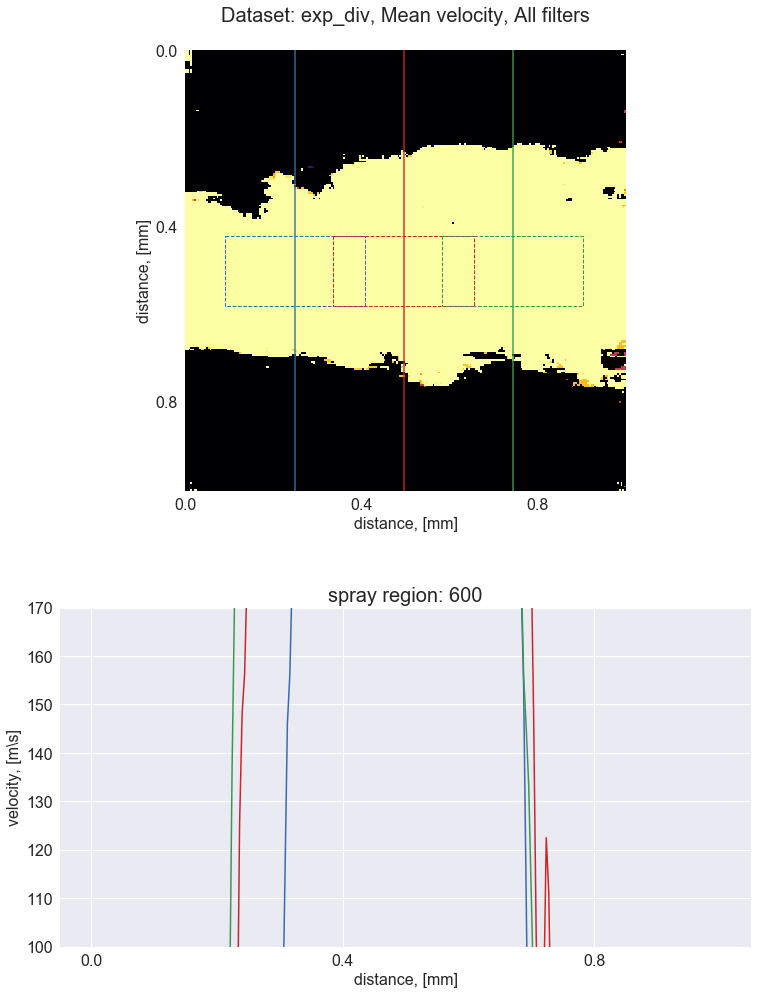

In [21]:
plot_velocity_map = True
plot_profiles = True
plot_time_evolution = False

#make_analysis_figure(nofilter, 'Mean velocity, No filter', 'amp_mean_nofilter')
#make_analysis_figure(corr_filter, 'Mean velocity, Correlation filter', 'amp_mean_filter_corr')
#make_analysis_figure(amp_filter, 'Mean velocity, Velocity filter', 'amp_mean_filter_amp')
#make_analysis_figure(peak_filter, 'Mean velocity, Peak filter', 'amp_mean_filter_peak')#
make_analysis_figure(all_filter, 'Mean velocity, All filters', 'amp_mean_filter_all')

## Flow Components 

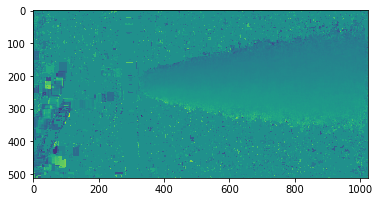

OK


In [28]:
# Get filtered flow components
fx, fy = filter_and_summarize_components(images, corr, peak, flow_x, flow_y)


fy_mean = avg_non_zero_full(fy)
#amp_mean_filtered_center = np.mean(filtered_peak_mean[cy-ry:cy+ry,cx-rx:cx+rx])
fy_std = np.apply_along_axis(std_nonzero, 0, fy)

im_res = Image.fromarray(fy_mean*vel_factor)
im_res.save(results_path + dataset + '_Tile_d' +region + '_flow_y_mean.tif')

im_res = Image.fromarray(fy_std*vel_factor)
im_res.save(results_path + dataset + '_Tile_d' +region + '_flow_y_std.tif')

plt.imshow(fy_mean*vel_factor)
plt.show()

print('OK')

In [112]:
dataset = '17_3_7_3'

reg_num = 4
region = regions[reg_num]

path_input = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\' + dataset + '\\' + dataset + '_Tile_d' +region + '\\'
#path_input = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\test\\' + dataset + '_Tile_d' +region + '\\'
results_path = path_input

amp_filtered = np.array(Image.open(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter.tif'))


In [98]:
pd.set_option('display.width', 1000)

# Patch size for measurement
px = 5
py = 5

step_in_mm = 0.1
step_in_pixels = int(step_in_mm * 1000 / pixel_size)
print(step_in_pixels)
    
n = 9

vert_values = ['y:{0:.1f}mm'.format(x*step_in_pixels*pixel_size /1000) for x in np.arange(-(n-1)/2, (n-1)/2+1)]
columns = ['Dataset', 'Tile', 'Dist'] + vert_values
df = pd.DataFrame(columns=columns )


37


NameError: name 'amp_filtered' is not defined

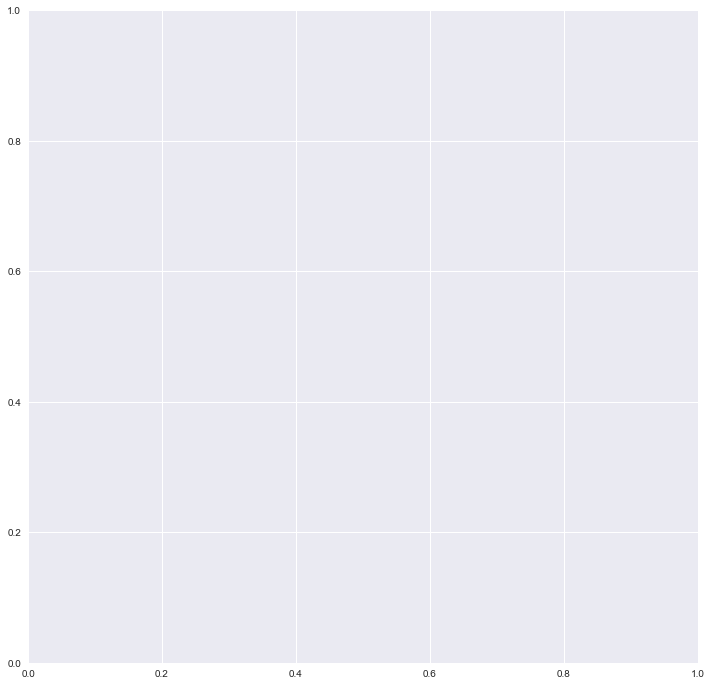

In [8]:
fig = plt.figure(1)
fig.set_size_inches(12, 12, forward=True)

ax = plt.subplot(111)

ax.imshow(amp_filtered, vmin=vel_min, vmax=vel_max, cmap='inferno')
ax.grid(False)

if reg_num == 0:
    last_pos = -step_in_mm
        
last_pos = summarize_velocity_profiles(amp_filtered, df, ax, last_pos, n)
plt.show()



In [119]:
p = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\' + dataset + '\\' + dataset + '_results_all_regions.xlsx' 
print(p)
df.to_excel(p, sheet_name='Results')

y:\projects\pn-reduction\2018_09_esrf_me1516\Phantom\17_3_7_3\17_3_7_3_results_all_regions.xlsx


In [17]:
v = df['y:0.0mm'].values.astype(np.float)
x = df['Dist'].values.astype(np.float)


plt.plot(x, v)
plt.ylim(50, 170)
plt.show()

NameError: name 'df' is not defined

## Testing

In [97]:
def test_averaging_methods_correlation(): 
    
    #------------------------------------------------
    # Filtering according to physical contraints
    #------------------------------------------------
    
    width = 512
    height = 256
    
    cx = int(width / 2) 
    cy = int(height / 2)
    
    min_vel_in_pixels = 0
    max_vel_in_pixels = 20
    
    filtered_amp = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels], axis=0), images, 0)
    amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp)
    im_res = Image.fromarray(amp_filtered_mean*vel_factor)
    im_res.save(results_path + 'test_amp_mean_filter.tif')
    
    print(np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor))
    
    
    c_list = np.arange(0, 0.4, 0.02)
    res = []
    
    for c in tqdm(c_list):
            
        filtered_corr = np.where(corr > c, 1, 0)
        filtered_amp2 = filtered_amp*filtered_corr
        amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp2)

        #im_res = Image.fromarray(amp_filtered_mean*vel_factor)
        #im_res.save(results_path + 'test_amp_mean_filter_corr.tif')

        mean_vel_in_center = np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor)
        
        res.append(mean_vel_in_center)
        
        #print(mean_vel_in_center)
    
    plt.plot(c_list, res)
    plt.title('No magnitude filtering, Minimal valid correlation')
    plt.xlabel('Correlation coefficient')
    plt.ylabel('Velocity, m/s')
    plt.show()
    
    print(res)
    #data_amp = amp_filtered_mean*vel_factor
    
    #plt.hist(data_amp.flatten())
    #plt.show()

In [14]:
def test_averaging_methods_min_max(): 
    
    #------------------------------------------------
    # Filtering according to physical contraints
    #------------------------------------------------
    
    width = 1024
    height = 512
    
    cx = int(width / 2) 
    cy = int(height / 2)
    
    amp_mean = np.mean(images, axis=0)
    amp_mean_value = np.mean(amp_mean[cy-ry:cy+ry,cx-rx:cx+rx])
    print('Mean unfiltered:', amp_mean_value*vel_factor)
    
    filtered_corr = np.where(corr > min_corr_value, 1, 0)
    
    #amp_median = np.median(images, axis=0)
    #print('Median unfiltered:', np.mean(amp_median[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor))
    
    # Make outliers filtering
    min_vel_in_pixels = (1.0 - 0.5)*amp_mean_value
    max_vel_in_pixels = (1.0 + 0.5)*amp_mean_value
    
    print('Velocity outliers:', min_vel_in_pixels*vel_factor, max_vel_in_pixels*vel_factor)

    filtered_amp = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels], axis=0), images, 0)
    amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp)
    amp_mean_filtered_value = np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx])
    print('Mean 50% outliers filtered:', amp_mean_filtered_value*vel_factor)
    
    amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp*filtered_corr)
    amp_mean_filtered_value = np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx])
    print('Mean 50% outliers filtered, correlation filtered:', amp_mean_filtered_value*vel_factor)
    
      
    perc = np.arange(0.1, 0.7, 0.05)
    #perc = np.array([0.1, 0.25, 0.5])
    
    res_unfiltered = []
    res_filtered = []
    
    for p in tqdm(perc):
    
        min_vel_in_pixels = (1.0 - p)*amp_mean_value
        max_vel_in_pixels = (1.0 + p)*amp_mean_value
    
        filtered_amp = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels], axis=0), images, 0)
        amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp*filtered_corr)
        mean_vel_in_center = np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor)
    
        res_unfiltered.append(mean_vel_in_center)
        
        min_vel_in_pixels = (1.0 - p)*amp_mean_filtered_value
        max_vel_in_pixels = (1.0 + p)*amp_mean_filtered_value
    
        filtered_amp = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels], axis=0), images, 0)
        amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp*filtered_corr)
        mean_vel_in_center = np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor)
    
        res_filtered.append(mean_vel_in_center)
    
    return res_unfiltered, res_filtered
    
    #print(res)
    #data_amp = amp_filtered_mean*vel_factor
    
    #plt.hist(data_amp.flatten())
    #plt.show()

In [7]:
test_averaging_methods_correlation()



NameError: name 'test_averaging_methods_correlation' is not defined

In [58]:
res_unfiltered, res_filtered = test_averaging_methods_min_max()

Mean unfiltered: 133.0679785121571
Velocity outliers: 66.53398925607856 199.60196776823568
Mean 50% outliers filtered: 142.6377735354684
Mean 50% outliers filtered, correlation filtered: 141.5551656627158


100%|██████████████████████████████████████████| 12/12 [06:59<00:00, 35.35s/it]


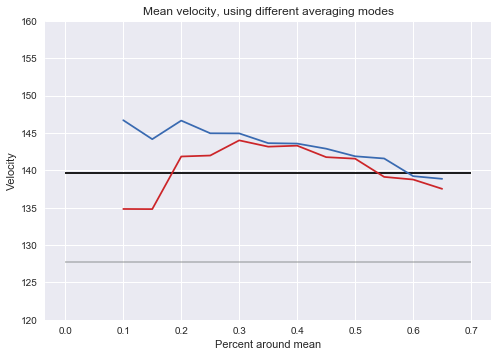

In [59]:
#print(res)

plt.style.use('seaborn')

perc = np.arange(0.1, 0.7, 0.05)

plt.plot(perc, res_unfiltered, color=red)
plt.plot(perc, res_filtered, color=blue)
plt.hlines(127.76, 0, 0.7, color=grey, alpha=0.5)
plt.hlines(139.6, 0, 0.7, color='black')
plt.title('Mean velocity, using different averaging modes')
plt.xlabel('Percent around mean')
plt.ylabel('Velocity')
plt.ylim(120, 160)
plt.savefig('y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\' + dataset + '\\' + dataset + '_d7.5_vel_filtering_fig.png')
plt.show()


In [16]:
print(11*1.5)
print(11*0.5)

16.5
5.5


## Summarize processed data: All datasets

Processing dataset:  018_1

Processing region: Z0Y0
Reading data...
Time elapsed:  16.040581703186035
Summarizing data...
mean: 149.69158321619034
corr>0.2: 151.96163189968635
amp +/- 50%: 153.47248762845993
peak: 154.13651272018004
all: 154.13646640486596
std all: 10.605424485253243
Making figures...
Done

Processing region: Z2.5Y0
Reading data...
Time elapsed:  15.855165719985962
Summarizing data...
mean: 130.62359202991834
corr>0.2: 140.4059618758373
amp +/- 50%: 150.47160116108984
peak: 153.38653572993346
all: 153.35865601678813
std all: 11.323065088802666
Making figures...
Done

Processing region: Z5Y0
Reading data...
Time elapsed:  16.26381015777588
Summarizing data...
mean: 121.1369355971163
corr>0.2: 126.51573076949482
amp +/- 50%: 147.27280735969543
peak: 152.26792406980738
all: 152.3076212003973
std all: 12.758454235749332
Making figures...
Done
Processing dataset:  023_1

Processing region: Z0Y0
Reading data...
Time elapsed:  16.081127643585205
Summarizing data...
mean: 149.

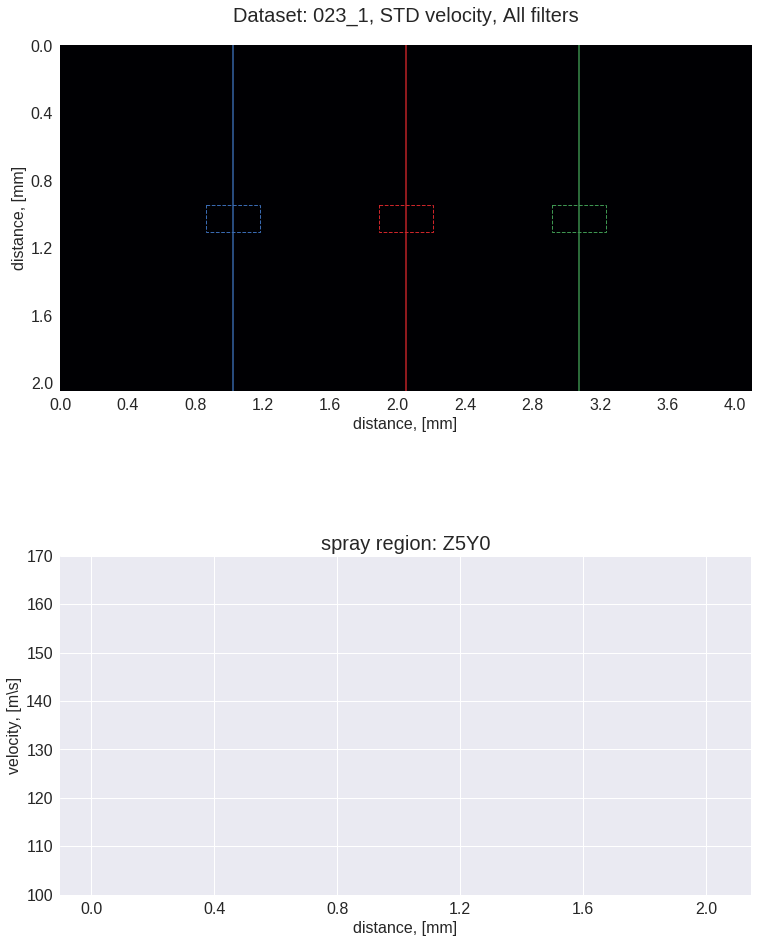

In [13]:

#path = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\'

path = u'/mnt/LSDF/projects/pn-reduction/2018_09_esrf_me1516/Phantom/'
    
all_data_frames = []

# Experiment: 2018_09_ersf_mi1516
datasets = ['17_3_5_1', '17_3_7_3','17_3_18_1','17_3_23_1']
regions = ['0', '2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20']

# Experiment: 2018_03_ersf_mi1315
datasets = ['018_1', '023_1']
regions = ['Z0Y0', 'Z2.5Y0', 'Z5Y0']

#datasets = ['17_3_5_1']
#regions = ['0']


pd.set_option('display.width', 1000)

run_velocity_magnitude = True
run_components_analysis = False

#------------------------------------
# Settings for vertical profiles 
#------------------------------------
# Patch size for measurement
px = 5
py = 5
step_in_mm = 0.1
step_in_pixels = int(step_in_mm * 1000 / pixel_size)
n = 11 # Number of vertical regions to measure


for ds in datasets:
    
    dataset = ds
    
    print('=====================================')
    print('Processing dataset: ', ds)
    print('=====================================')

    # Create an empty data frame
    vert_values = ['y:{0:.1f}mm'.format(x*step_in_pixels*pixel_size /1000) for x in np.arange(-(n-1)/2, (n-1)/2+1)]
    columns = ['Dataset', 'Tile', 'Dist', 'Filter'] + vert_values
    df = pd.DataFrame(columns=columns )

    for r in regions:

        region = r

        print('\nProcessing region:', r)

        #path_input = path + dataset + '\\' + dataset + '_Tile_d' +region + '\\'
        #path_input = path + dataset + '/' + dataset + '_Tile_d' +region + '/'
        
        # Experiment: 2018_03_ersf_mi1315
        path_input = (u'/mnt/LSDF/projects/pn-reduction/2018_03_esrf_mi1325/Phantom/Glasduese/Nachtschicht 09.3 auf 10.3/'
                        + dataset +
        '/Ansicht 0°/OP_1bar_25°C_100bar_25°C/' + 
                        region + '/' + dataset + '_Tile_d' +region + '/')
        
        results_path = path_input
        file_name = dataset + '_Tile_d' +region+'.tif'
        
        
 
        print ('Reading data...')
        start = time.time()    
        
        images = read_tiff(path_input + dataset + '_Tile_d' +region +'_amp_seq.tif', max_read_images)
        corr   = read_tiff(path_input + dataset + '_Tile_d' +region + '_corr_seq.tif', max_read_images)
        peak   = read_tiff(path_input + dataset + '_Tile_d' +region + '_peak_seq.tif', max_read_images)
        flow_x   = read_tiff(path_input + dataset + '_Tile_d' +region + '_flow_x_seq.tif', max_read_images)
        flow_y   = read_tiff(path_input + dataset + '_Tile_d' +region + '_flow_y_seq.tif', max_read_images)

        end = time.time()
        print ('Time elapsed: ', (end-start))
        
        plot_velocity_map = True
        plot_profiles = True
        plot_time_evolution = False
        
        print ('Summarizing data...')
        
        if run_velocity_magnitude:
        
            nofilter, corr_filter, amp_filter, peak_filter, all_filter, std_all_filter = filter_and_summarize_velocities(images, corr, peak, flow_x, flow_y)

            print ('Making figures...')
            make_analysis_figure(nofilter, 'Mean velocity, No filter', 'amp_mean_nofilter')
            make_analysis_figure(corr_filter, 'Mean velocity, Correlation filter', 'amp_mean_filter_corr')
            make_analysis_figure(amp_filter, 'Mean velocity, Velocity filter', 'amp_mean_filter_amp')
            make_analysis_figure(peak_filter, 'Mean velocity, Peak filter', 'amp_mean_filter_peak')
            make_analysis_figure(all_filter, 'Mean velocity, All filters', 'amp_mean_filter_all')
            make_analysis_figure(std_all_filter, 'STD velocity, All filters', 'amp_std_filter_all')

            measures_list = [(nofilter, 'no'),
                       (corr_filter, 'corr'),
                       (amp_filter, 'amp'),
                       (peak_filter, 'peak'),
                       (all_filter, 'all'),
                       (std_all_filter, 'std_all')]

            reg_num = regions.index(r)
            if reg_num == 0:
                last_pos = -step_in_mm

            # Measure velocity profiles
            last_pos = summarize_velocity_profiles(measures_list, df, last_pos, n)
            
        #if run_components_analysis:
            
            # Get filtered flow components
            #fx, fy = filter_and_summarize_components(images, corr, peak, flow_x, flow_y)
            

        print('Done')


    all_data_frames.append(df)

    p = path + dataset + '/' 
    
    p = (u'/mnt/LSDF/projects/pn-reduction/2018_03_esrf_mi1325/Phantom/Glasduese/Nachtschicht 09.3 auf 10.3/'
                        + dataset +
        '/Ansicht 0°/OP_1bar_25°C_100bar_25°C/')
    
    df.to_excel(p + dataset + '_results_all_regions.xlsx', sheet_name='Results')
    df.to_pickle(p + dataset + '_results_all_regions.pkl')
    

print('Finished and Saved')

In [14]:
#datasets = ['17_3_5_1', '17_3_7_3','17_3_18_1','17_3_23_1']

#path = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\'
path = u'/mnt/LSDF/projects/pn-reduction/2018_09_esrf_me1516/Phantom/'

plt.style.use('seaborn')

In [43]:
def plot_vel_timeline(df, measure, label, linestyle = '-'):
    
    df = df[df.Filter == measure]
    
    #vert_profiles = ['y:0.3mm', 'y:0.2mm', 'y:0.1mm', 'y:0.0mm', 'y:-0.1mm', 'y:-0.2mm', 'y:-0.3mm']    
    vert_profiles = ['y:0.2mm', 'y:0.1mm', 'y:0.0mm', 'y:-0.1mm', 'y:-0.2mm'] 
    #vert_profiles = ['y:0.0mm', 'y:-0.1mm', 'y:-0.2mm']
    
    avg_res = []
    
    for v in vert_profiles:      
        vals = df[v].values.astype(np.float)
        avg_res.append(vals) 

    x = df['Dist'].values.astype(np.float)
    
    print(len(x))

    v = np.max(avg_res, axis=0)

    x = x[2:77]
    v = v[2:77]
    
    plt.plot(x,v, label= label + ' ' + measure, linestyle = linestyle )

227
227
227
227
227


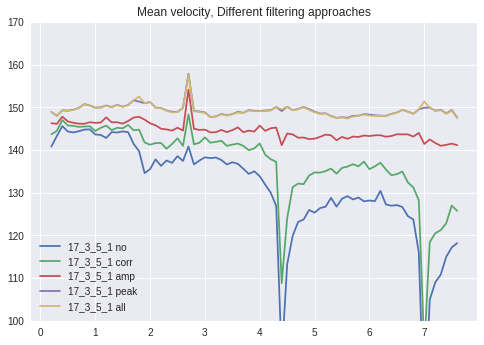

In [44]:
i = 0

datasets = ['17_3_5_1']

for d in datasets:
    p = path + d + '/'
    df = pd.read_excel(p + d + '_results_all_regions.xlsx')
    
    
    plot_vel_timeline(df, 'no', d)
    plot_vel_timeline(df, 'corr', d)
    plot_vel_timeline(df, 'amp', d)    
    plot_vel_timeline(df, 'peak', d)
    plot_vel_timeline(df, 'all', d)

    plt.ylim(100, 170)
    i = i+1
        
plt.legend()
plt.title('Mean velocity, Different filtering approaches')
plt.show()      

227
227
227
227


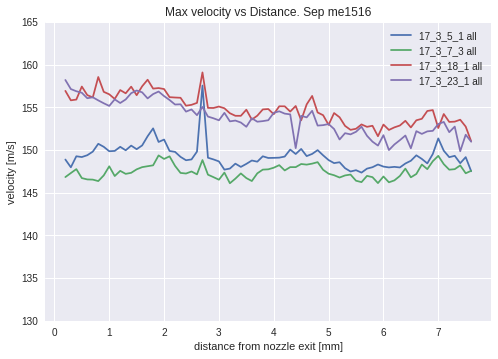

In [53]:
i = 0

datasets = ['17_3_5_1', '17_3_7_3', '17_3_18_1', '17_3_23_1']
#datasets = ['17_3_5_1']

datasets = datasets[:]

for d in datasets:
    p = path + d + '/'
    df = pd.read_excel(p + d + '_results_all_regions.xlsx')
    
    plot_vel_timeline(df, 'all', d)

    i = i+1


plt.ylim(130, 165)

plt.legend()
plt.title('Max velocity vs Distance. Sep me1516')
plt.xlabel('distance from nozzle exit [mm]')
plt.ylabel('velocity [m/s]')

plt.savefig(u'/mnt/LSDF/projects/pn-reduction/2018_03_esrf_mi1325/Phantom/Glasduese/plot_Sep_mi1516.png')

plt.show()  

79
79
79
79


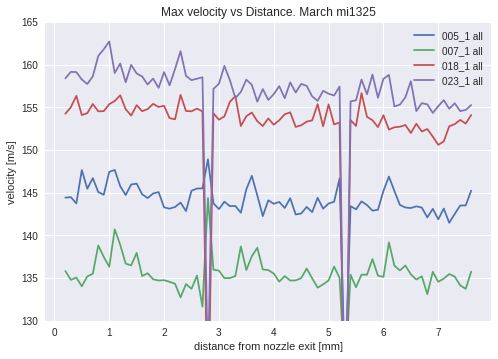

In [54]:
p_18 = (u'/mnt/LSDF/projects/pn-reduction/2018_03_esrf_mi1325/Phantom/Glasduese/Nachtschicht 09.3 auf 10.3/018_1/Ansicht 0°/OP_1bar_25°C_100bar_25°C/')
p_23 = (u'/mnt/LSDF/projects/pn-reduction/2018_03_esrf_mi1325/Phantom/Glasduese/Nachtschicht 09.3 auf 10.3/023_1/Ansicht 0°/OP_1bar_25°C_100bar_25°C/')
p_05 = (u'/mnt/LSDF/projects/pn-reduction/2018_03_esrf_mi1325/Phantom/Glasduese/Nachtschicht 10.3 auf 11.3/005_1/OP_1bar_25°C_100bar_25°C/')
p_07 = (u'/mnt/LSDF/projects/pn-reduction/2018_03_esrf_mi1325/Phantom/Glasduese/Nachtschicht 10.3 auf 11.3/007_1/OP_1bar_25°C_100bar_25°C/')


df_18 = pd.read_excel(p_18 + '018_1_results_all_regions.xlsx')
df_23 = pd.read_excel(p_23 + '023_1_results_all_regions.xlsx')
df_05 = pd.read_excel(p_05 + '005_1_results_all_regions.xlsx')
df_07 = pd.read_excel(p_07 + '007_1_results_all_regions.xlsx')


plot_vel_timeline(df_05, 'all', '005_1')
plot_vel_timeline(df_07, 'all', '007_1')
plot_vel_timeline(df_18, 'all', '018_1')
plot_vel_timeline(df_23, 'all', '023_1')

plt.ylim(130, 165)

plt.legend()
plt.title('Max velocity vs Distance. March mi1325')
plt.xlabel('distance from nozzle exit [mm]')
plt.ylabel('velocity [m/s]')

plt.savefig(u'/mnt/LSDF/projects/pn-reduction/2018_03_esrf_mi1325/Phantom/Glasduese/plot_Mar_mi1325.png')

plt.show()


## Collect results

In [24]:
print(len(df_05))

474


In [25]:
from shutil import copyfile

path = u'/mnt/LSDF/projects/pn-reduction/2018_09_esrf_me1516/Phantom/'
    
#datasets = ['17_3_5_1', '17_3_7_3','17_3_23_1']
regions = ['0', '2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20']

path_result = 'results'

datasets = ['17_3_5_1', '17_3_7_3','17_3_18_1','17_3_23_1']
#regions = ['0']


for dataset in datasets:
    
    make_dir(path + dataset + '/' + path_result)
    
    print(dataset)
    
    
    i = 1
    
    for reg in regions:
        
        dataset_name = dataset + '_Tile_d' + reg
        tile_path = path + dataset + '/' + dataset_name + '/'
        
        os.rename(tile_path+dataset+'_fig_amp_mean_filter_all.png', tile_path+dataset + '_' + str(i).zfill(2) + '_Tile_d' + reg+'_fig_amp_mean_filter_all.png')
        os.rename(tile_path+dataset+'_fig_amp_mean_filter_amp.png', tile_path+dataset + '_' + str(i).zfill(2) + '_Tile_d' + reg+'_fig_amp_mean_filter_amp.png')
        os.rename(tile_path+dataset+'_fig_amp_mean_filter_corr.png', tile_path+dataset + '_' + str(i).zfill(2) + '_Tile_d' + reg+'_fig_amp_mean_filter_corr.png')
        os.rename(tile_path+dataset+'_fig_amp_mean_filter_peak.png', tile_path+dataset + '_' + str(i).zfill(2) + '_Tile_d' + reg+'_fig_amp_mean_filter_peak.png')
        os.rename(tile_path+dataset+'_fig_amp_mean_nofilter.png', tile_path+dataset + '_' + str(i).zfill(2) + '_Tile_d' + reg+'_fig_amp_mean_nofilter.png')

        new_dataset_name = dataset + '_' + str(i).zfill(2) + '_Tile_d' + reg
        
        os.rename(tile_path+dataset_name+'_amp_mean_filter_all.tif', tile_path+new_dataset_name+'_amp_mean_filter_all.tif')
        os.rename(tile_path+dataset_name+'_amp_std_filter_all.tif', tile_path+new_dataset_name+'_amp_std_filter_all.tif')
        os.rename(tile_path+dataset_name+'_amp_mean_nofilter.tif', tile_path+new_dataset_name+'_amp_mean_nofilter.tif')
        
        copyfile(tile_path+new_dataset_name+'_amp_mean_filter_all.tif', path + dataset + '/' + path_result + '/' + dataset + '_amp_' + str(i).zfill(2) + '_Tile_d' + reg + '_amp_mean_filter_all.tif')
        copyfile(tile_path+new_dataset_name+'_amp_std_filter_all.tif', path + dataset + '/' + path_result + '/' + dataset + '_std_' + str(i).zfill(2) + '_Tile_d' + reg + '_amp_std_filter_all.tif')
        copyfile(tile_path+new_dataset_name+'_fig_amp_mean_filter_all.png', path + dataset + '/' + path_result + '/' + dataset + '_fig_' + str(i).zfill(2) + '_Tile_d' + reg + '_amp_mean_filter_all.png')
        
        i += 1
        
        print(reg)
        
        
        
        
        
        

17_3_5_1


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/LSDF/projects/pn-reduction/2018_09_esrf_me1516/Phantom/17_3_5_1/17_3_5_1_Tile_d0/17_3_5_1_fig_amp_mean_filter_all.png' -> '/mnt/LSDF/projects/pn-reduction/2018_09_esrf_me1516/Phantom/17_3_5_1/17_3_5_1_Tile_d0/17_3_5_1_01_Tile_d0_fig_amp_mean_filter_all.png'

## Presentation

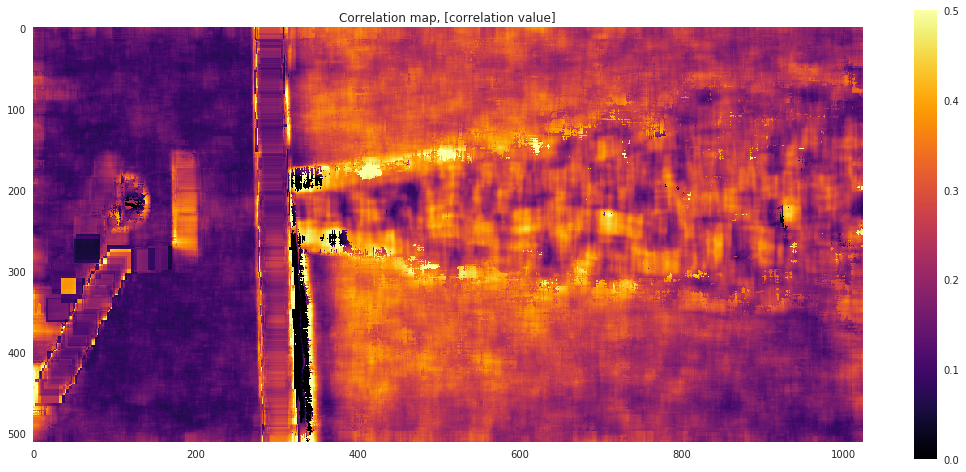

In [125]:
frame = 1


path_output = u'/mnt/LSDF/projects/pn-reduction/2018_09_esrf_me1516/Phantom/presentation/'

fig = plt.figure(1)
fig.set_size_inches(18, 7, forward=True)
plt.subplots_adjust(top=0.95, bottom=0.06, left=0.1, right=0.90, hspace=0.3 )
    
im = corr[frame]
plt.imshow(im, vmax=0.5, cmap='inferno')
plt.colorbar()
plt.grid(False)
plt.title('Correlation map, [correlation value]')
plt.show()

fig.savefig(path_output + 'fig_correlation.png')



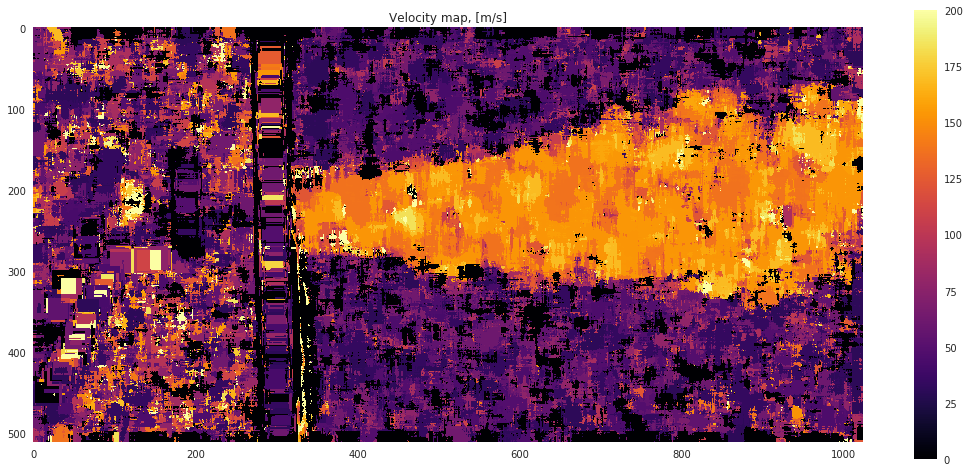

In [124]:
fig = plt.figure(1)
fig.set_size_inches(18, 7, forward=True)
plt.subplots_adjust(top=0.95, bottom=0.06, left=0.1, right=0.90, hspace=0.3 )
    
im = images[frame]
plt.imshow(im*vel_factor, vmax=200, cmap='inferno')
plt.colorbar()
plt.grid(False)
plt.title('Velocity map, [m/s]')
plt.show()

fig.savefig(path_output + 'fig_velocty_map.png')